<a href="https://colab.research.google.com/github/DSNortsev/CSE545-Artificial-Intelligence/blob/master/Project4/project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
#@title Genetic Algorithm
crossover_rate = 0.65 #@param {type:"slider", min:0, max:1, step:0.01}
mutation_rate = 0.87 #@param {type:"slider", min:0, max:1, step:0.01}
crossover_method = 'Partially Mapped Crossover' #@param ['Order crossover', 'Maximal Preservative Crossover', 'Partially Mapped Crossover']
mutation_method = 'Swap' #@param ['Swap', 'Insertion', 'Displacement']  

In [139]:
from collections import defaultdict
import matplotlib.pyplot as plt
from operator import itemgetter
from random import randrange, sample, random, randint
import networkx as nx
from math import ceil
import re
import os

class Graph:
    '''
    Graph class that accpets file path as an argument
    '''
    
    def __init__(self, path):
        self.MUTATION_RATE = mutation_rate
        self.CROSSOVER_RATE = crossover_rate
        self.CROSSOVER_METHOD = crossover_method
        self.MUTATION_METHOD = mutation_method
        self.ELIT_PERCENT = 30
        self.RANDOM_PERCENT = 70
        # Coordinates of all nodes in the graph
        self._coordinates = self.read_tsp_file(path)
        # List of all nodes 
        self._cities = [*self._coordinates.keys()]
        # Total number of nodes
        self._size = len(self._cities)
        # Distances between each nodes in the graph
        self._distances = self.compute_distances()
        # File index to generate a file name of the plot images
        self._file_index = 0
        # Direcotry to keep all plots 
        self._GRAPH_DIR = 'graphs/'
        self.reset_file_index()

        # Mapping dictionary to crossover and mutation methods
        self.__crossovers = {
            'Order crossover': 'order_crossover',
            'Maximal Preservative Crossover': 'maximal_preservative_crossover',
            'Partially Mapped Crossover': 'partially_mapped_crossover'
            }

        self.__mutations = {
            'Swap': 'swap_mutation',
            'Insertion': 'insertion_mutation',
            'Displacement': 'displacement_mutation'
        }   
      
    def reset_file_index(self):
        '''
        This method is reseting the index of the file name when generating graphs and removing all plots  
        '''
        self._file_index = 0
        
        full_path = os.path.abspath(self._GRAPH_DIR)

        for file in os.listdir(self._GRAPH_DIR):
            if file == '.keep':
                continue
            os.remove(os.path.join(full_path, file))  
        return
    

    def read_tsp_file(self, path):
        """"
        Read TSP file
        """
        city_list = []

        with open(path, 'r') as f:
            _data = re.findall(r'\n([0-9].*)', f.read())

        # Split each line by space and convert to float
        for line in _data:
            city_list.append(tuple(map(float, line.split())))
        return { int(vertex): (x,y) for vertex, x, y in city_list }
    
    
    def euclidean_distance(self, cityA, cityB):
        """
        Formula to calculate the Euclidean distance 
        """
        # Math library
        import math
        
        x1 = self._coordinates[cityA][0]
        y1 = self._coordinates[cityA][1]
        x2 = self._coordinates[cityB][0]
        y2 = self._coordinates[cityB][1]
        return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    def total_distance(self, tour):
      """
      Calculate total distance by passing completed tour 
      For example: [1, 2, 3, 4, 1]
      """
      total_distance = 0
      for i in range(1, len(tour)):
          total_distance += graph._distances[tour[i-1]][tour[i]]

      # Check if the rout is the closed cycle 
      if tour[0] != tour[-1]:
        total_distance += graph._distances[tour[-1]][tour[0]]
      return round(total_distance, 2)


    def create_route(self):
      '''
      Create route method create a random route from the city list
      '''
      route = sample(self._cities, len(self._cities))
      return route


    def create_init_population(self, population_size):
      '''
      Create initial population method accepts one argument, which is the size 
      of random population to create and return N number of random routes
      '''
      population = []

      for i in range(0, population_size):
        population.append(self.create_route())
      return population


    def rank_routes(self, population):
      '''
      Accepts population list and returns normalized weights
      between 0 and 1
      '''

      fitness_score = {}

      for i, tour in enumerate(population):
        # Since we are interested in lowest distnace
        # we need to devide 1 by total distance
        fitness_score[i] =  1 / (self.total_distance(tour) + 1)
        # print(i, self.total_distance(tour))
        #fitness_score[i] = self.total_distance(tour)
      
      # Calculate total fitness sctore for all routes
      total_score = sum(fitness_score.values())
      
      # Normalize the score
      for k, v in fitness_score.items():
        fitness_score[k] = round(fitness_score[k] / total_score, 4)
      return sorted(fitness_score.items(), key = itemgetter(1), reverse=True)


    def pick_tour(self, fintess_score ):
      '''
      Choose tour based on it is total cost
      '''
      index = 0 
      random_number = random()

      while random_number > 0:
        random_number -= fintess_score[index][1]
        # print(random_number, index)
        index += 1
        # Pick up the last element if index is greater then total
        if index >= len(fintess_score):
          break
      return fintess_score[index-1]

    def selection(self, fitness):
      '''
      Selection methods accepts list of touple with index and normalized costs\
      and returns a list of indexes of selected routs
      '''
      # Select 20% of rouets with the minimum cost and 30 randomly
      # Total selection is 50% from population
      # ELIT_PERCENT = 30
      # RANDOM_PERCENT = 70
      elit_index = ceil((len(fitness)*self.ELIT_PERCENT)/100)
      result = [tour[0] for tour in fitness[:elit_index]] 

      # Generate population based on RANDOM_PERCENT value
      for i in range(ceil((len(fitness)*self.RANDOM_PERCENT)/100)):  
        result.append(graph.pick_tour(fitness)[0])
      return result

    def mating_pool(self, population, selection_results):
      '''
      Mating pool methods accpets the following argiments:
      - population which is a list of tours 
      - selection results whihc is an index of all selected routs in the tour
      '''
      return [population[i] for i in selection_results]


    # Cross over methods
    def order_crossover(self, p1, p2):
      '''
      Use orser crossover algorithm to swap cities
      '''
      cut_start = randint(1, len(p1) - 2)
      cut_end = randint(cut_start + 1, len(p1))

      # print(f'Cut start: {cut_start}, Cut end: {cut_end}')

      c1, c2, p1, p2 = p1[cut_start:cut_end],\
                       p2[cut_start:cut_end],\
                       p1[cut_end:] + p1[:cut_end],\
                       p2[cut_end:] + p2[:cut_end]
      # print(c1,c2, p1, p2, sep='\n')
      
      c1.extend([i for i in p2 if i not in c1])
      c2.extend([i for i in p1 if i not in c2])
      return c1, c2


    def maximal_preservative_crossover(self, p1, p2):
      '''
      Use maximal preservative algorithm to swap cities
      '''
      # Find how many elemets to swap
      c = len(p1) // 2
      # Find starting point
      r = randrange(len(p1) + 1)
      # Extend the list, which will allow to move back to index 0
      c1, c2 = (p1 * 2)[r:r + c], (p2 * 2)[r:r + c]
        
      c1.extend([i for i in p2 if i not in c1])
      c2.extend([i for i in p1 if i not in c2])
      return c1,c2

    def partial_mapping(self, p, c, s, e):
      '''
      Method accepts 4 argumets: p - parent, c - child, s - start index
      e - end index,  and open 40% of genes in child 
      '''
      # Genearte a set of all parent indices
      p_index = set(range(len(p)))
      # Generate a set of cut indeces
      cut_index = set(range(s,e))
      # Find differnce of indices
      left_index = list(p_index - cut_index)
      # Find 40% of indices to open 
      total_open = ceil(len(left_index) * 0.4)
      # Get Random indices
      random_index = sample(left_index, total_open)
      # Open indices in child tour
      for i in random_index:
        if p[i] not in c:
          c[i] = p[i] 
      return c

    def partially_mapped_crossover(self, p1, p2):
      # Find start and end index
      s = randint(1, len(p1) - 2)
      e = randint(s + 1, len(p1))

      # print(f'S: {s}, E: {e}')

      # Swap cut part between parents
      c1, c2 = [0] * len(p1), [0] * len(p2)
      c2[s:e], c1[s:e] = p1[s:e], p2[s:e]

      # Open partial genes 
      c1 = self.partial_mapping(p1, c1, s, e)
      c2 = self.partial_mapping(p2, c2, s, e)
      
      # print(f'{c1}, {c2}\n')
      # Complete tour
      for i in p2:
        if i not in c1:
          c1[c1.index(0)] = i

      for i in p1:
        if i not in c2:
          c2[c2.index(0)] = i
      return c1, c2


    # Mutation algorithms
    def swap_mutation(self, tour):
      '''
      Swap mutation method accepts one argument, which is a generated
      tour by selection.
      
      To perform swap mutation select two alleles at random and
      swap their positions. It preserves most of the adjacency
      information but links broken disrupts order more
      '''
      i, j = sample(range(len(tour)),2)
      # print(i, j)
      tour[i], tour[j] = tour[j], tour[i]
      return tour

    def insertion_mutation(self, tour):
      '''
      Insertion mutation method accepts one argument, which is a generated
      tour by selection.

      It is used in Permutation encoding. First of all, pick two allele values
      at random. Then move the second allele to follow the first, shifting the
      rest along to accommodate. Note that this preserves most of the order 
      and the adjacency information
      '''
      random_city, random_position = sample(range(len(tour)),2)
      # print(random_city, random_position)
      city = tour.pop(random_city)
      # print(city)
      tour.insert(random_position, city)
      return tour

    def displacement_mutation(self, tour):
      '''
      Displacement mutation method accepts one argument, which is a generated
      tour by selection.

      Displacement mutation inserts a random string of cities in another 
      random place. 
      '''

      # Find start and end index
      s = randint(1, len(tour) - 2)
      e = randint(s + 1, len(tour))

      # print(f'S: {s}, E: {e}')
      random_position = randint(0, len(tour))
      # print(random_position)
      substring = tour[s:e]
      # print(substring)
      tour = tour[:s] + tour[e:]
      return tour[:random_position] + substring + tour[random_position:]

    def create_new_generation(self, current_generation):
      # Find the name of crossover and mutation methods to use
      crossover = self.__crossovers[self.CROSSOVER_METHOD]
      mutation = self.__mutations[self.MUTATION_METHOD]
      # Create a list of indices from population with normalized weights
      fitness = graph.rank_routes(current_generation)
      # print(*fitness, sep = "\n")
      
      best_route = current_generation[fitness[0][0]]
      # print(f'Best Route: {best_route}\nBest weights: {self.total_distance(best_route)}')

      # SELECTION STEP
      # Select method chooses 50% of current population when 20% is routs with
      # best costs and 30% is random with high probabilty of best routes 
      selection_result = graph.selection(fitness)
      # print(len(selection_result))
      # Generate a mating pool from current population based on indices from
      # selection result 
      mating_pool = graph.mating_pool(current_generation, selection_result)
      # print(Counter(selection_result))
      # print(selection_result, '\n\n')
      # print(*mating_pool, sep = "\n")
      # next_generation = []
      # elit_index = ceil(self.ELIT_PERCENT/len(mating_pool))
      next_generation = []
      # print(f'TEMP1: {best_route}')

      # CROSSOVER STEP
      # print(f'Next Generation: {next_generation}')
      for pair in zip(mating_pool[::2], mating_pool[1::2]):
          next_generation.extend(getattr(self, crossover)(*pair)\
                                 if random() < self.CROSSOVER_RATE else pair)

      #     print(pair)
      # print(f'Next Generation after Crossover:')
      # print(*next_generation, sep='\n')

      # MUTATION STEP
      next_generation = [getattr(self, mutation)(tour)\
                         if random() < self.MUTATION_RATE else tour\
                         for tour in next_generation]

      # next_generation.extend(best_rout)
      # print(f'TEMP2: {best_route}')
      # print('Before')
      # print(*next_generation, sep='\n')
      # next_generation.append(best_route)
      # print('\nAfter')
      # print(*next_generation, sep='\n')

      # print(f'Next Generation after Mutation:')
      # print(*next_generation, sep='\n')
      # print('\n')
      # order the generation according to the fitness value
      next_generation = sorted(next_generation, key=self.total_distance)
      # print(f'Next Gen: {len(next_generation)}')
      # print(*next_generation, sep = "\n")
      # Create a list of indices from population with normalized weights
      # fitness = graph.rank_routes(next_generation)
      # print(*next_generation, sep='\n')
      # print(*fitness, sep = "\n")
      # best_route_2 = next_generation[fitness[0][0]]
      # total_cost_2 = self.total_distance(best_route_2)
      best_route = next_generation[0]
      total_cost = self.total_distance(best_route)
      # print(f'BR1: {best_route}\nBW1: {total_cost}')
      # print(f'BR2: {best_route_2}\nBW2: {total_cost_2}')
      # print(f'Best Route: {best_rout}\nBest weights: {total_cost}')
      return next_generation, best_route, total_cost 






    # def genetic_algorithm(self, popSize=10, eliteSize, mutationRate, generations):
    def genetic_algorithm(self, pop_size=10, term_count=100):
      '''
      Genetic algorithm method accepts the following arguments:
      - pop_size is the size of random initial tours, Default value is 100
      - term_count indicates when to terminate an algorithms after not improving 
        the total cost
      '''
      # Generate initial population 
      population = self.create_init_population(pop_size)
      total_cost = float('inf')
      # print(f'Inital population {len(population)}')
      # print(*population, sep='\n')
      # Run specified amount of generations
      # for _ in range(0, generations):
      #    result = self.create_new_generation(population)
      #    population = result[0]
      #    if result[2] < total_cost:
      #        best_route = result[1]
      #        total_cost = result[2]

      term_index = 0
      generations = 0
      best_routes = []
      while term_index <= term_count:
        generations += 1
        result = self.create_new_generation(population)
        population = result[0]
        if result[2] < total_cost:
            best_route = result[1]
            total_cost = result[2]
            # print(f'Best Route: {best_route}\nBest weights: {total_cost}')
            # print(f'Total number generations: {generations}')
            # Create a list of tuples that contains the best route which is
            # completed cycle, total weights and number of total generations
            best_routes.append((result[1] + [result[1][0]], result[2], generations))
            term_index = 0
        else:
          term_index += 1
      return best_routes
      # print(f'FINAL Best Route: {best_route}\nBest weights: {total_cost}')
      # print(f'Total number generations: {generations}')
      # print(*best_routes, sep='\n')

        #  print(f'Best Route: {best_route}\nBest weights: {total_cost}')
      # print(*population, sep='\n')
      # print(f'FINAL Best Route: {best_route}\nBest weights: {total_cost}') 

        # # Create a list of indexes from population with normalized weights
        # fitness = graph.rank_routes(population)
        # print(*fitness, sep = "\n")
        # print(f'Best Route: {population[finess[0][0]]}\n
        #         Best weights: {self.compute_distances(population[finess[0][0]])}')



      # print(*population, sep='\n')
      # print(f'Inital best distance: ')


      # print(f'Best Route: {population[graph.rank_routes(population)[0][0]]}')
      # # Select method to choose tours with heights probabilty of lowest weights 
      # selection_result = graph.selection(fitness, 15)
      # mating_pool = graph.mating_pool(population, selection_result)
      # pop = initialPopulation(popSize, population)
      # print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
      
      # for i in range(0, generations):
      #     pop = nextGeneration(pop, eliteSize, mutationRate)
      
      # print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
      # bestRouteIndex = rankRoutes(pop)[0][0]
      # bestRoute = pop[bestRouteIndex]
      # return bestRoute

      
    # def add(self, i, j, k):
    #     """
    #     Add method find the cost of adding node k between node i and node j
    #     """
    #     return round(self._distances[i][k] + self._distances[k][j] - self._distances[i][j], 2)

    
    def compute_distances(self):
        """
        Compute distance method invokes at initialization and calculates the cost of each edge in the graph
        """
        self.distances = defaultdict(dict)
        for cityA in self._cities:
            for cityB in self._cities:
                if cityA != cityB and cityB not in self.distances[cityA]:
                    distance = self.euclidean_distance(cityA, cityB)
                    self.distances[cityA][cityB] = round(distance, 2)
                    self.distances[cityB][cityA] = round(distance, 2)   
        return self.distances
    
    
    # def closest_neighbor(self, tour, node, in_tour=False):
    #     """
    #     Find the closest node which is/is not in the tour, based on the in_tour flag
    #     """
    #     neighbors = self._distances[node]
    #     current_dist = [(c, d) for c, d in neighbors.items()
    #                     if (c in tour if in_tour else c not in tour)]
    #     return sorted(current_dist, key=itemgetter(1))[0]

    
    
    # def nearest_insertion(self):
    #     '''
    #     Returns a tuple with a list of all completed cycles and total weights
    #     '''
    #     # Choose ramdom city
    #     city = randrange(1, self._size)
    #     # Initiate a list of current tour and all completed tours
    #     tour, tours = [city], []
    #     # Find the closest node to the first random node which is not in the tour yet
    #     neighbor, distance = self.closest_neighbor(tour, city, False)
    #     # Add second node to the tour
    #     tour.append(neighbor)
    #     count = 0
    #     # Run while loop untill all nodes are visited
    #     while len(tour) != self._size:
    #         best, dist = None, float('inf')          
    #         # Selection step, find node which is not in the tour but the closest to any node 
    #         # in the tour
    #         for candidate in self._cities:
    #             if candidate in tour:
    #                 continue
    #             #  Consider only the distances to nodes already in the tour
    #             _, length = self.closest_neighbor(tour, candidate, True)
    #             if length < dist:
    #                 best, dist = candidate, length
    #         count += 1
    #         if count == len(self._cities):
    #             break
            
    #         # Find an edge (𝑖,𝑗) such that 𝑑𝑖𝑘+𝑑𝑘𝑗−𝑑𝑖𝑗 is minimal     
    #         index, dist = None, float('inf')
    #         # Complete the cycle in the tour
    #         tour = tour + [tour[0]]
    #         for i in range(len(tour) - 1):
    #             add = self.add(tour[i], tour[i + 1], best)
    #             if add < dist:
    #                 index, dist = i, add
    #         tour.insert(index + 1, best)
    #         tours.append(tour)
    #         # Remove the cycle from the tour and to insert the next closest node
    #         tour = tour[:-1] 
    #     print(tours[-1])
    #     total_cost = self.total_distance(tours[-1])
    #     return (tours, total_cost)

    def plot_graph(self, tour_info, weights=False): 
        '''
        Plot a function 
        '''
        tour = tour_info[0]
        tour_cost = tour_info[1]
        total_generations = tour_info[2]
        # Create new graph
        G = nx.Graph()
        pos = self._coordinates
        # Image name
        file_name = f'{self._file_index:0{len(str(self._size))}d}'

        # Add edges to the graph
        for i in range(len(tour)-1):
            G.add_edge(tour[i], tour[i+1], weight = self._distances[tour[i]][tour[i+1]])

        # Display weights of each edge
        if weights: 
            # Get weight for each edge 
            labels = nx.get_edge_attributes(G,'weight')
            # Drow weights to each edge
            nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

        # Add nodes 
        options = {"node_size": 500, "alpha": 0.5}
        nx.draw_networkx_nodes(G, pos, nodelist=list(pos.keys()), node_color="r", **options)

        # Draw in red edges that are not in shortest path
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=G.edges(),
            width=0.5,
            alpha=0.5,
            edge_color="r",
        )

        # Draw lables in the node
        nx.draw_networkx_labels(G,pos, font_size=10)

        # Increase the size of the plots
        fig = plt.gcf()
        fig.set_size_inches(18, 10.5)
        #plt.figure(1,figsize=(50,50))

        plt.axis("off")
        plt.title(f'Genetic Algorithm\nTotal Cost: {tour_cost}\n Total Generations: {total_generations}')
        plt.savefig(f'graphs/project_4_{file_name}.png')
        plt.show()
        # Generate the file name in ascending order 
        self._file_index += 1

    def draw_closest_insertion(self, tour, weights=False): 
        '''
        Plot a function 
        '''
        
        # Create new graph
        G = nx.Graph()
        pos = self._coordinates
        # Image name
        file_name = f'{self._file_index:0{len(str(self._size))}d}'

        # Add edges to the graph
        for i in range(len(tour)-1):
            G.add_edge(tour[i], tour[i+1], weight = self._distances[tour[i]][tour[i+1]])
        
        print(G)

        # Display weights of each edge
        if weights: 
            # Get weight for each edge 
            labels = nx.get_edge_attributes(G,'weight')
            # Drow weights to each edge
            nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

        # Add nodes 
        options = {"node_size": 500, "alpha": 0.5}
        nx.draw_networkx_nodes(G, pos, nodelist=list(pos.keys()), node_color="r", **options)

        # Draw in red edges that are not in shortest path
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=G.edges(),
            width=0.5,
            alpha=0.5,
            edge_color="r",
        )

        # Draw lables in the node
        nx.draw_networkx_labels(G,pos, font_size=10)

        # Increase the size of the plots
        fig = plt.gcf()
        fig.set_size_inches(18, 10.5)
        #plt.figure(1,figsize=(50,50))

        plt.axis("off")
        plt.title('Closest Insertion Algorithm')
        plt.savefig(f'graphs/project__{file_name}.png')
        plt.show()
        # Generate the file name in ascending order 
        self._file_index += 1

In [140]:
%%time
# Find besth path by using nearest insertion algorithm
# Instantiate graph 
graph = Graph('Random10.tsp')
print(graph.MUTATION_RATE)
print(graph.CROSSOVER_RATE)
print(graph.CROSSOVER_METHOD)
print(graph.MUTATION_METHOD)
# all_cycles = graph.nearest_insertion()

0.87
0.65
Partially Mapped Crossover
Swap
CPU times: user 1.26 ms, sys: 972 µs, total: 2.23 ms
Wall time: 1.71 ms


In [149]:
# Create a list of random populations from the city list
# population = graph.create_init_population(10)
# population
results = graph.genetic_algorithm(pop_size=50, term_count=100)
results


[([1, 2, 3, 7, 5, 10, 8, 6, 9, 4, 1], 134.18, 1),
 ([3, 4, 10, 5, 8, 7, 9, 6, 1, 2, 3], 125.28, 2),
 ([7, 5, 10, 4, 1, 3, 2, 9, 8, 6, 7], 124.11, 13),
 ([8, 9, 4, 3, 1, 2, 10, 5, 6, 7, 8], 119.23, 15),
 ([1, 8, 6, 7, 5, 9, 10, 4, 3, 2, 1], 116.94, 17),
 ([6, 5, 3, 2, 1, 4, 10, 9, 8, 7, 6], 115.78, 23),
 ([5, 10, 4, 9, 3, 2, 1, 8, 7, 6, 5], 115.48, 31),
 ([9, 1, 2, 3, 4, 10, 5, 8, 6, 7, 9], 114.12, 40),
 ([6, 7, 8, 9, 3, 1, 2, 4, 10, 5, 6], 110.75, 72),
 ([9, 8, 7, 6, 5, 10, 4, 1, 2, 3, 9], 108.38, 136)]

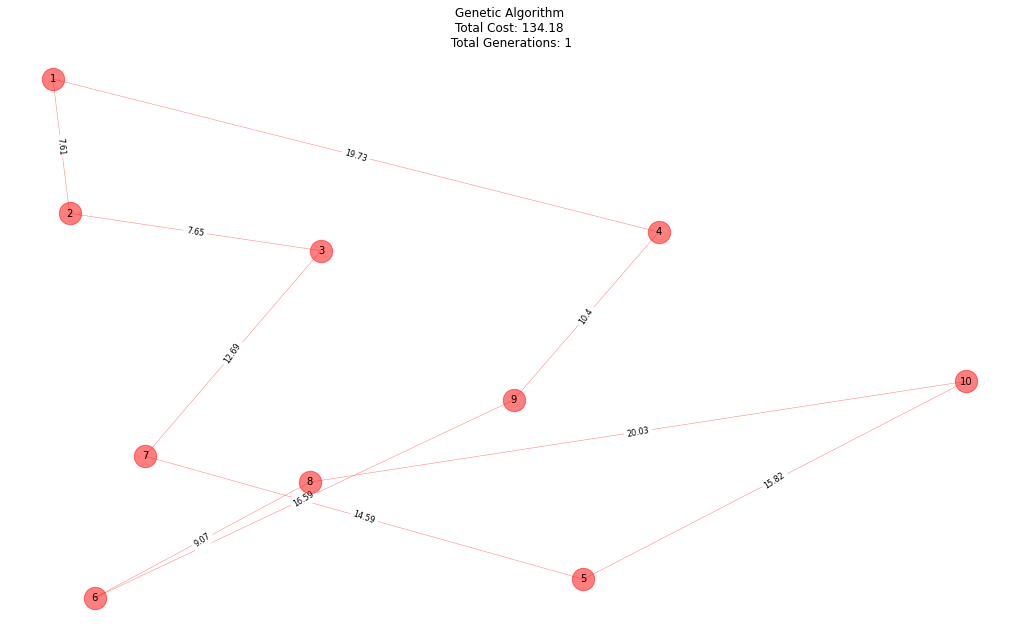

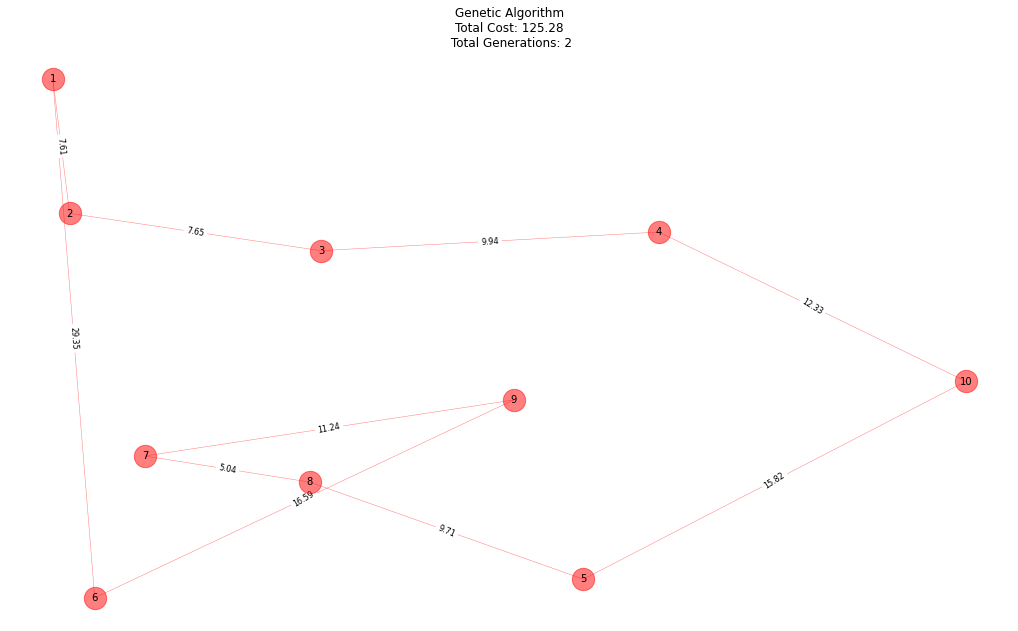

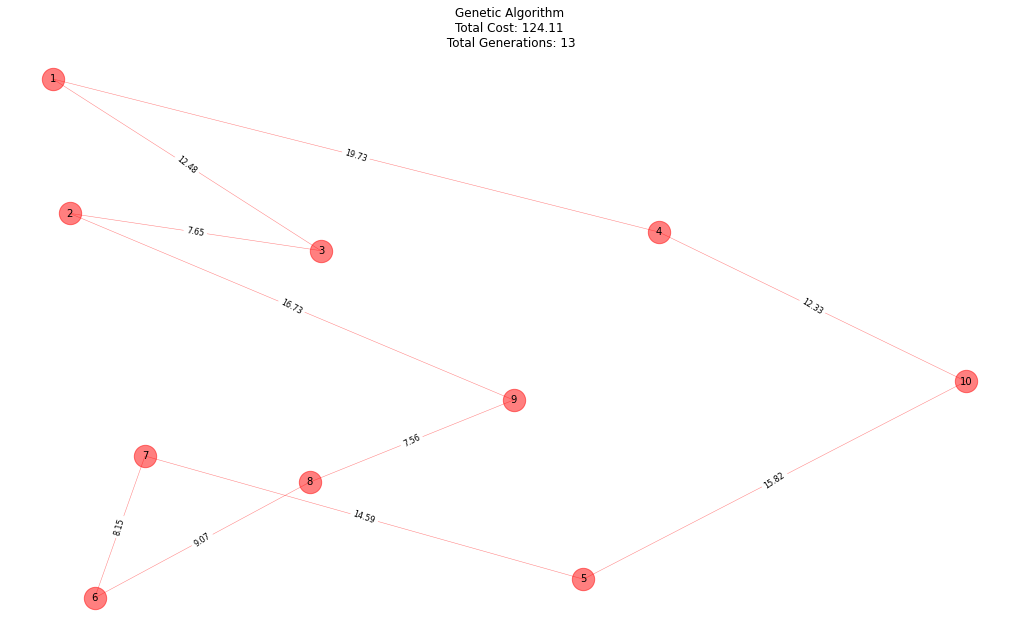

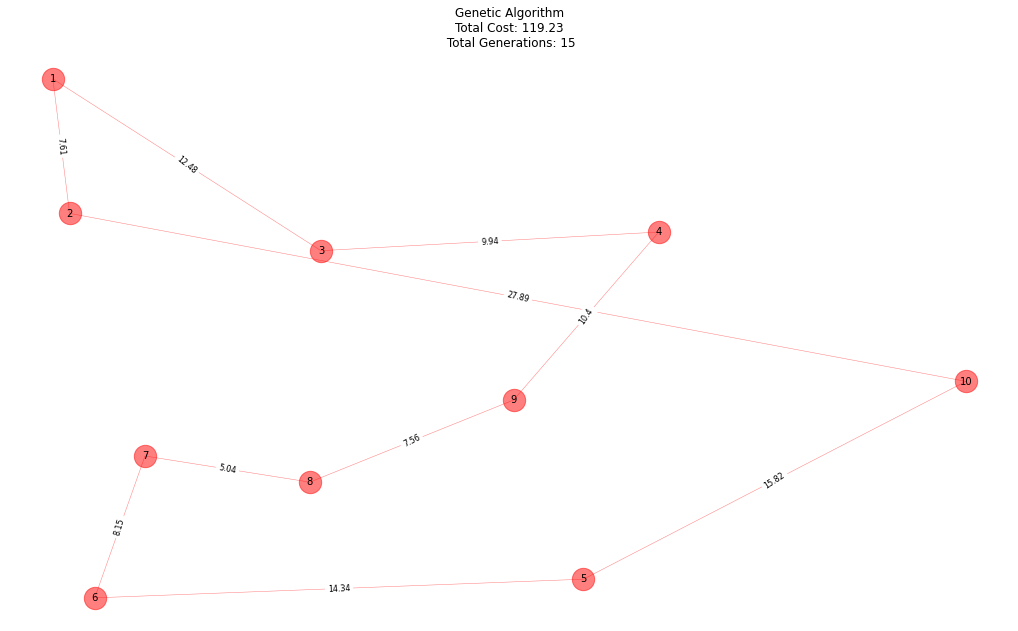

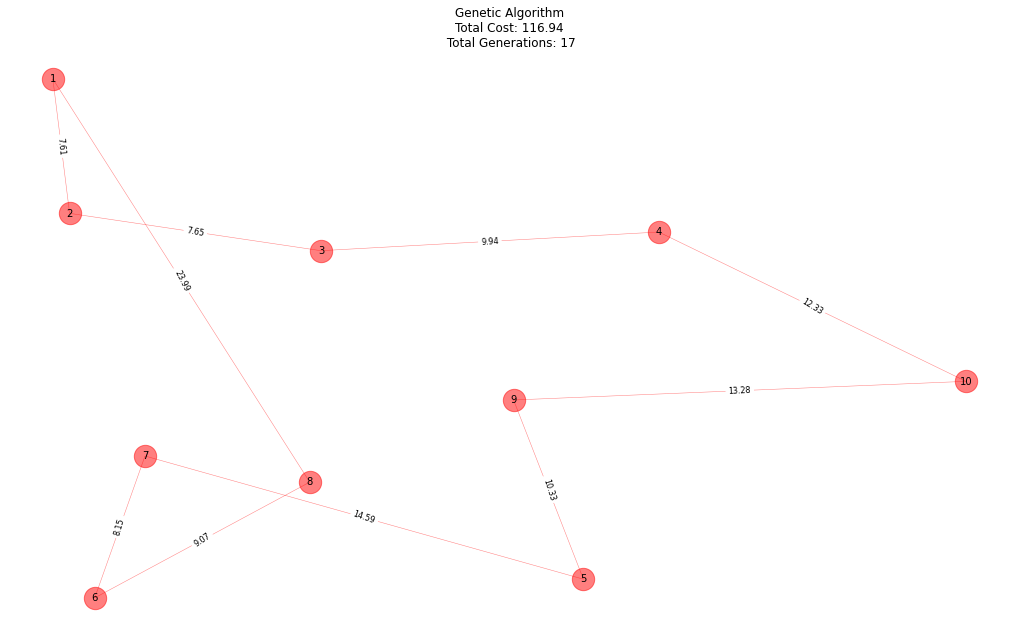

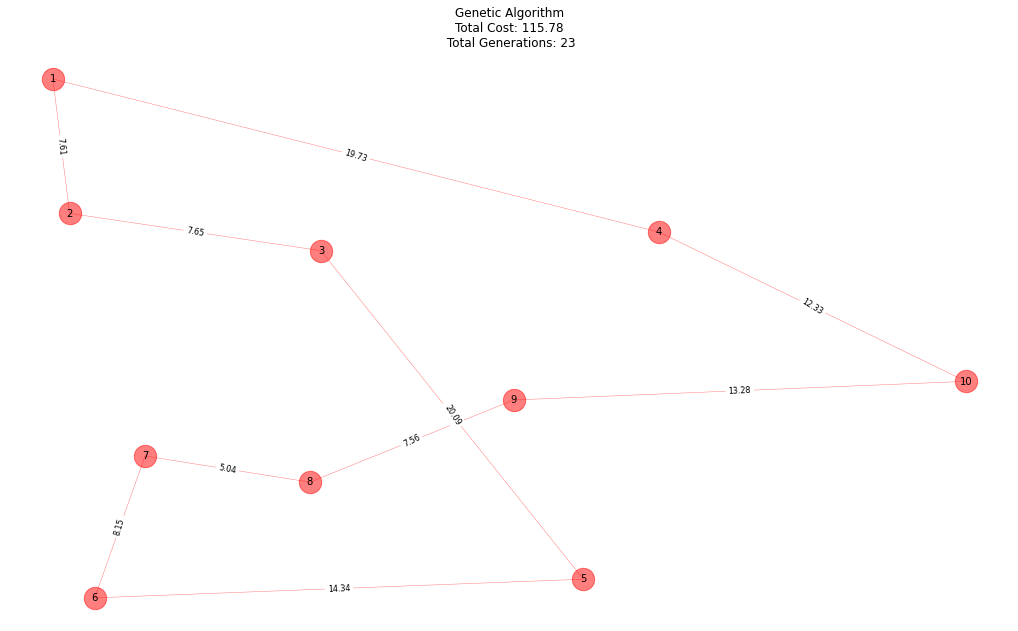

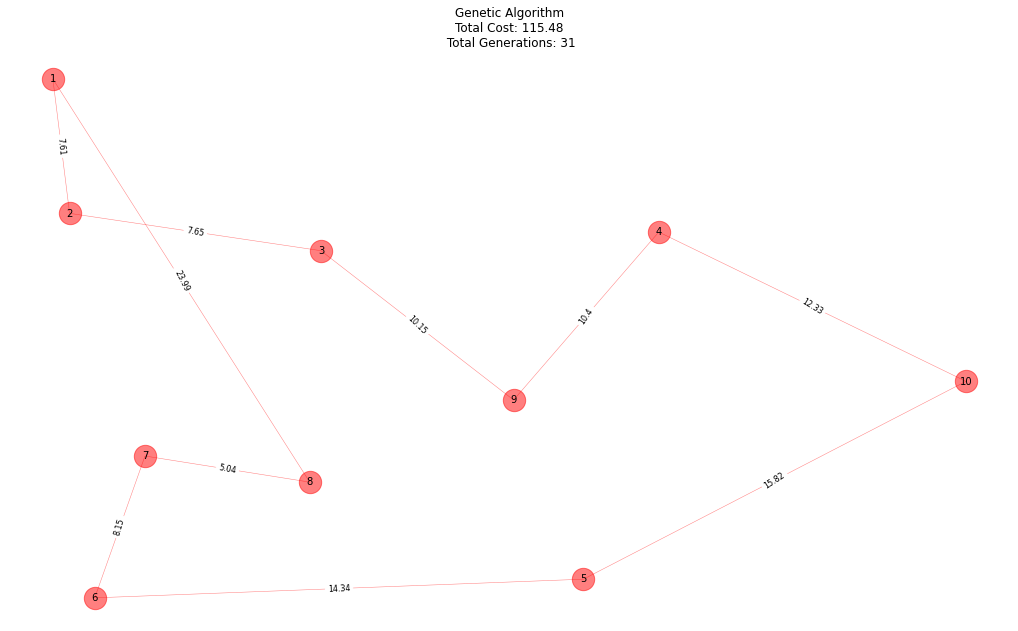

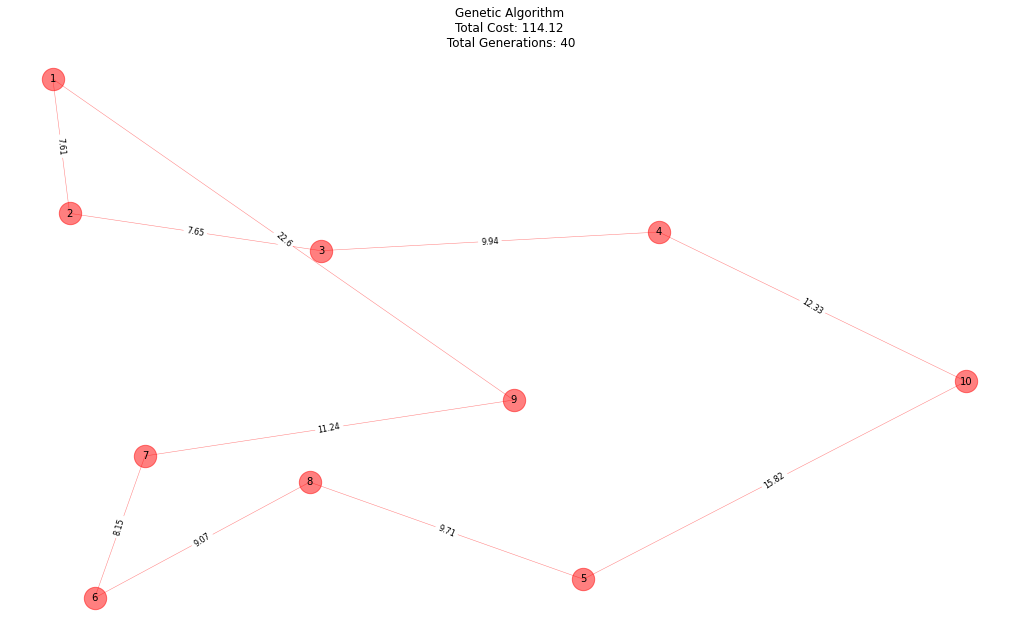

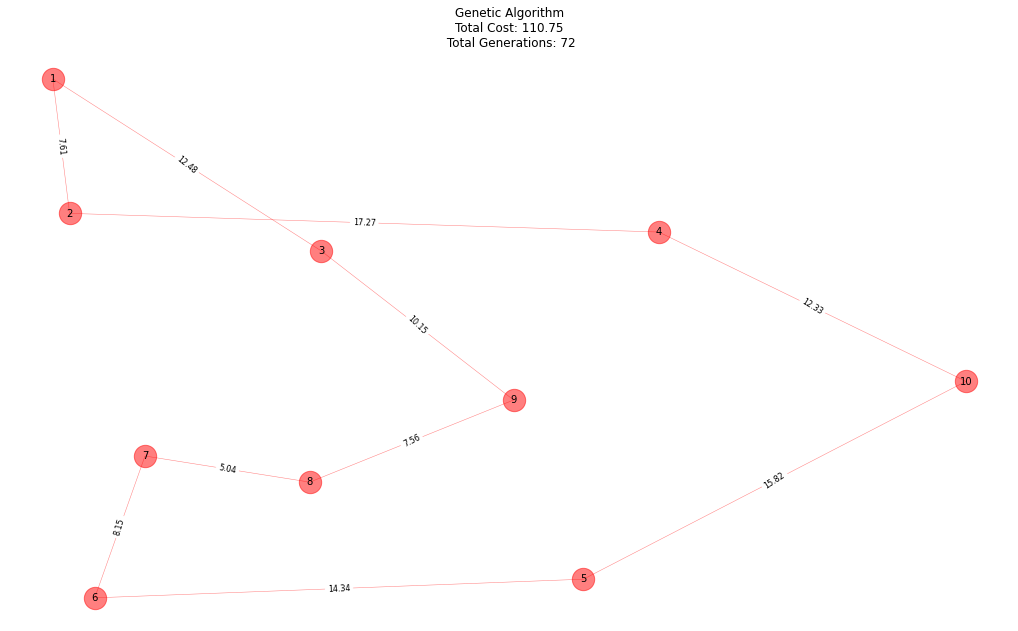

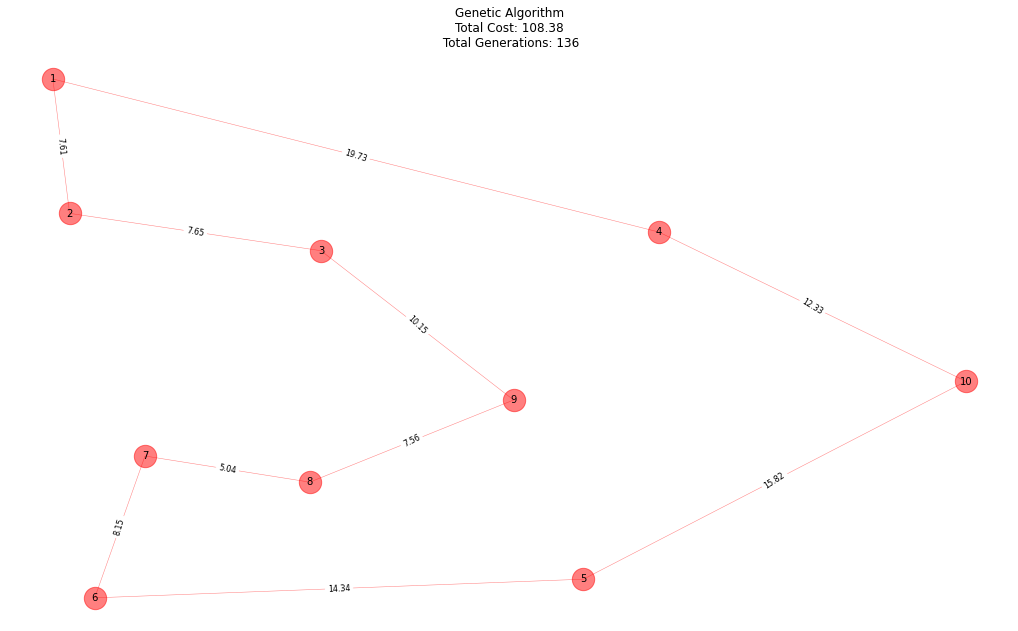

In [150]:
# Plot all paths in nearest insertion algorithm
# Reset index for file name and delete all images from graph directory
graph.reset_file_index()

for i in range(len(results)):
    graph.plot_graph(results[i], weights=True)

In [151]:
# Generate gif images from png plots

import os
import imageio

file_dir = 'genetic_algorithm.gif'
images_dir = 'graphs'
image_list = []

# Generate a list of absolute paths to the png images
filelist= sorted([os.path.abspath(f'{images_dir}/{file}') for file in os.listdir(images_dir) if file.endswith('.png')])
for file_name in filelist:
    image_list.append(imageio.imread(file_name))
    
# Create gif file 
kargs = { 'duration': 1 }
imageio.mimwrite(file_dir , image_list, **kargs)



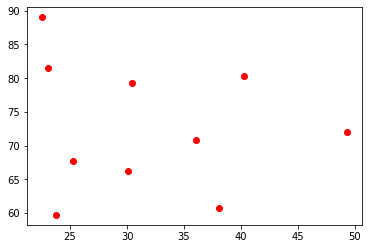

In [35]:
# Plot all nodes in the graph 
import matplotlib.pyplot as plt

x = [coord[0] for coord in graph._coordinates.values()]
y = [coord[1] for coord in graph._coordinates.values()]

plt.scatter(x, y, color='red')
plt.show()